In [8]:
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
from skimage.filters import try_all_threshold
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import resize
import skimage.morphology
import skimage.feature
import math
from math import sqrt
from skimage.color import rgb2gray
from skimage import measure
from skimage import data, util

(2, 512, 512)
uint16


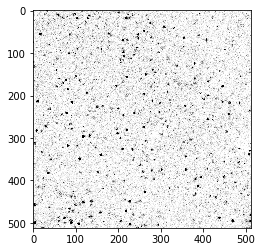

In [10]:
img = skimage.io.imread('112619_OGD_Treated_PI_5_regions_nonRGB_XY2.tif')
print(img.shape)
print(img.dtype)
imgplot = plt.imshow(img[0,:,:], cmap='Greys')
plt.show()

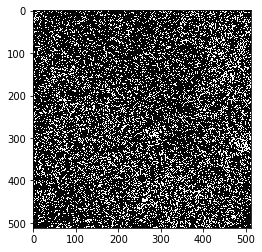

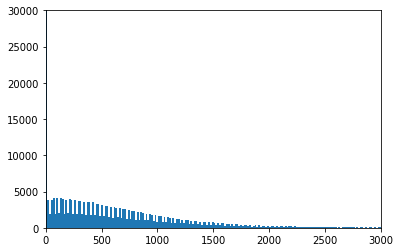

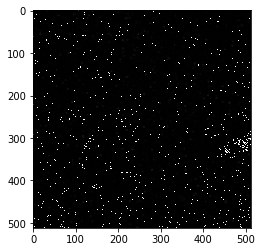

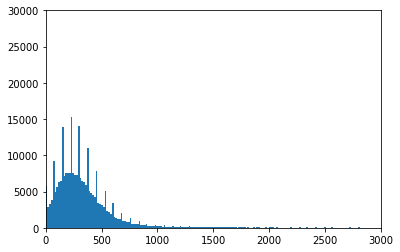

In [11]:
DAPI = img[0]
PI = img[1]

DAPIplot = plt.imshow(1-DAPI, cmap='Greys')
plt.show()
plt.hist(DAPI.ravel(), bins=256)
plt.ylim(0, 30000)
plt.xlim(0, 3000)
plt.show()
PIplot = plt.imshow(1-PI, cmap='Greys')
plt.show()
plt.hist(PI.ravel(), bins=256)
plt.ylim(0, 30000)
plt.xlim(0, 3000)
plt.show()

## DAPI channel processing

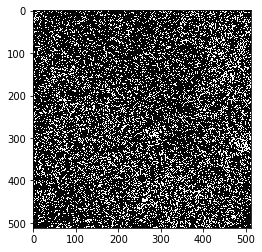

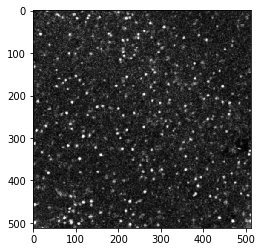

In [12]:
DAPI_filtered = ndi.gaussian_filter(DAPI, sigma=1)
DAPIplot = plt.imshow(1-DAPI, cmap='Greys')
plt.show()
filteredplot = plt.imshow(1-DAPI_filtered, cmap='Greys')
plt.show()

skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean


(<Figure size 1440x1296 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1184bd128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118928748>], dtype=object))

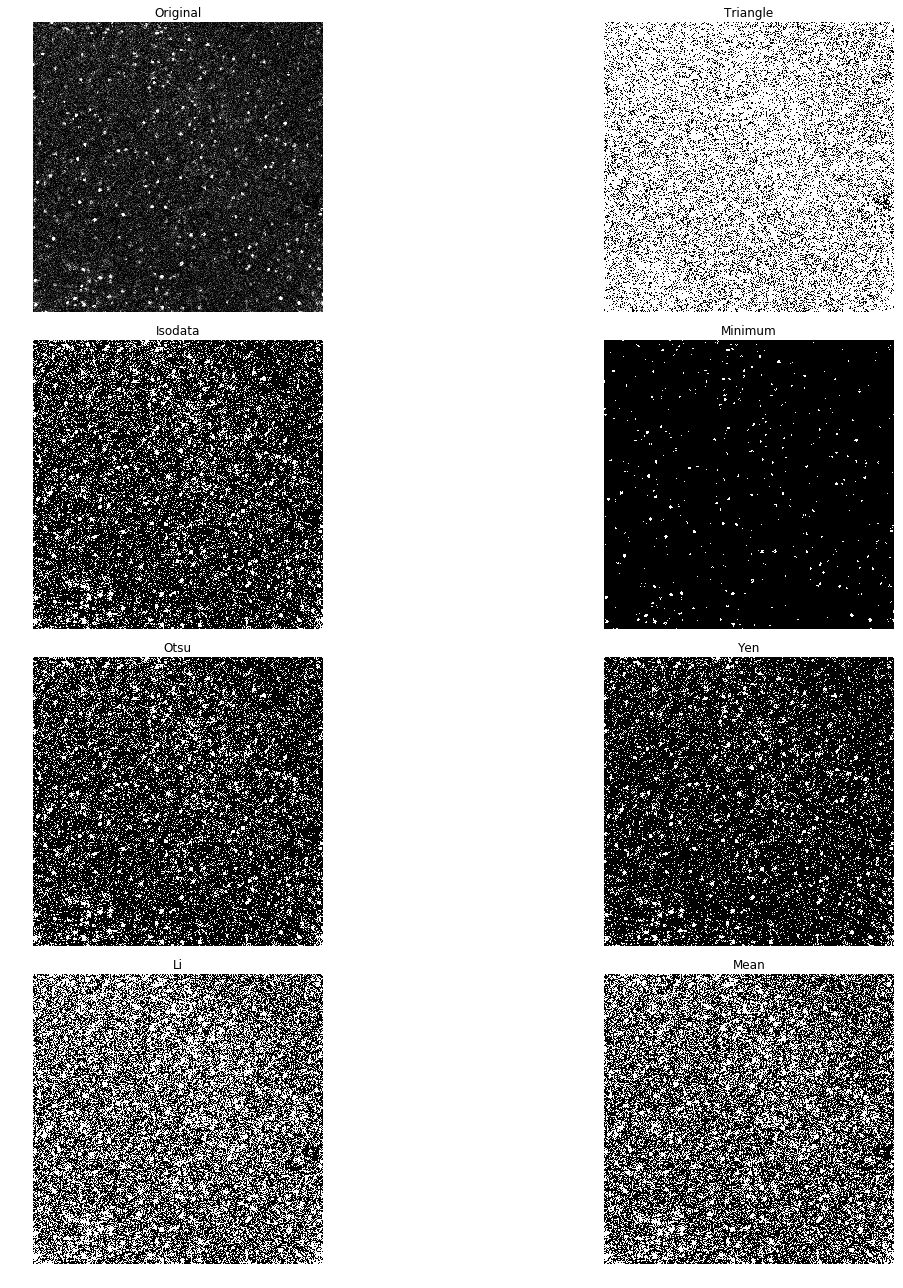

In [13]:
try_all_threshold(DAPI, figsize=(20,18))

In [ ]:
try_all_threshold(DAPI_filtered, figsize=(20,18))

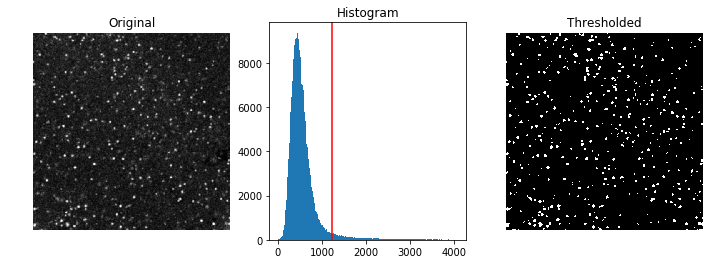

In [14]:
DAPI_thresh = skimage.filters.threshold_otsu(DAPI_filtered)
DAPI_binary = DAPI_filtered > DAPI_thresh

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(DAPI_filtered, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(DAPI_filtered.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(DAPI_thresh, color='r')

ax[2].imshow(DAPI_binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

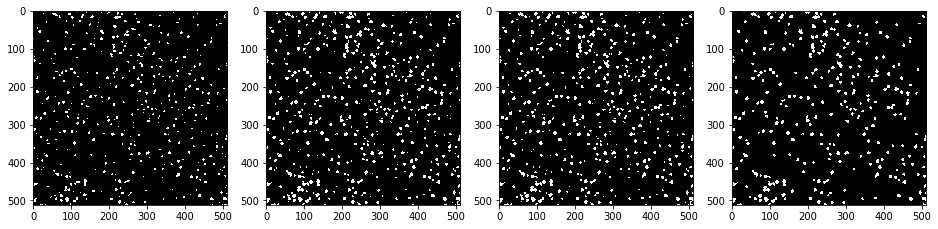

In [15]:
DAPI_dilation = skimage.morphology.binary_dilation(DAPI_binary)
DAPI_filled_holes = ndi.binary_fill_holes(DAPI_dilation)
DAPI_clean = skimage.morphology.remove_small_objects(DAPI_filled_holes, min_size=30)


fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
ax = axes.ravel()
ax[0] = plt.subplot(1, 4, 1)
ax[1] = plt.subplot(1, 4, 2)
ax[2] = plt.subplot(1, 4, 3)
ax[3] = plt.subplot(1, 4, 4)
ax[0].imshow(DAPI_binary, cmap=plt.cm.gray)
ax[1].imshow(DAPI_dilation, cmap=plt.cm.gray)
ax[2].imshow(DAPI_filled_holes, cmap=plt.cm.gray)
ax[3].imshow(DAPI_clean, cmap=plt.cm.gray)
plt.show()

In [16]:
log_blobs = skimage.feature.blob_log(DAPI_clean)
dog_blobs = skimage.feature.blob_dog(DAPI_clean)
doh_blobs = skimage.feature.blob_doh(DAPI_clean)

log_blobs[:, 2] = log_blobs[:, 2] * sqrt(1.5)
dog_blobs[:, 2] = dog_blobs[:, 2] * sqrt(1.5)
doh_blobs[:, 2] = doh_blobs[:, 2] * sqrt(1.5)

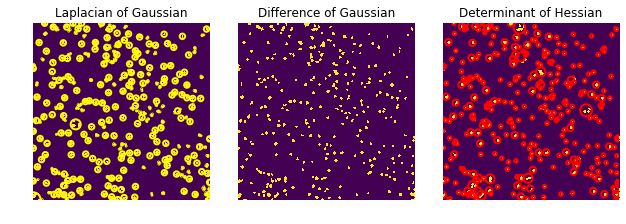

492 0 359


In [17]:
blobs_list = [log_blobs, dog_blobs, doh_blobs]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(DAPI_clean)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

print(len(log_blobs), len(dog_blobs), len(doh_blobs))

In [18]:
labeled_DAPI, _ = ndi.label(DAPI_clean)
DAPI_props = measure.regionprops(labeled_DAPI)

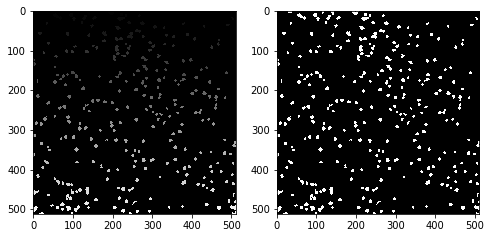

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[1] = plt.subplot(1, 2, 2)
ax[0].imshow(labeled_DAPI, cmap=plt.cm.gray)
ax[1].imshow(DAPI_clean, cmap=plt.cm.gray)

plt.show()

In [20]:
print(len(DAPI_props))
props_DAPI = pd.DataFrame(columns=['centroid x', 'centroid y', 'filled_area', 'area'])

k = 1
for props in DAPI_props:
    #Get the properties that I need for areas
    #Add them into a pandas dataframe that has the same number of rows as objects detected
    #
    centroid = props.centroid
    centroid_x = centroid[0]
    centroid_y = centroid[1]
    fill_area = props.filled_area
    area = props.area
    props_DAPI.loc[k] = [centroid_x, centroid_y, fill_area, area]
    k = k + 1

281


In [21]:
print(len(props_DAPI))
props_DAPI[:5]

281


,centroid x,centroid y,filled_area,area
1,2.063830,32.893617,47.0,47.0
2,2.757576,115.212121,33.0,33.0
3,3.884615,139.500000,52.0,52.0
4,3.900000,198.066667,120.0,120.0
5,7.982456,222.175439,57.0,57.0


## PI Channel Processing

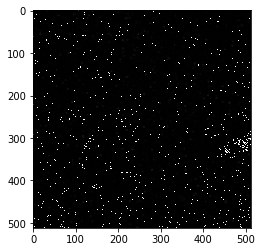

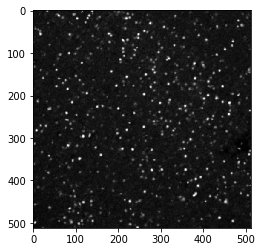

In [22]:
PI_filtered = ndi.gaussian_filter(PI, sigma=1)
PIplot = plt.imshow(1-PI, cmap='Greys')
plt.show()
filteredplot = plt.imshow(1-PI_filtered, cmap='Greys')
plt.show()

skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean


(<Figure size 1440x1296 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1197bd1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11985e400>], dtype=object))

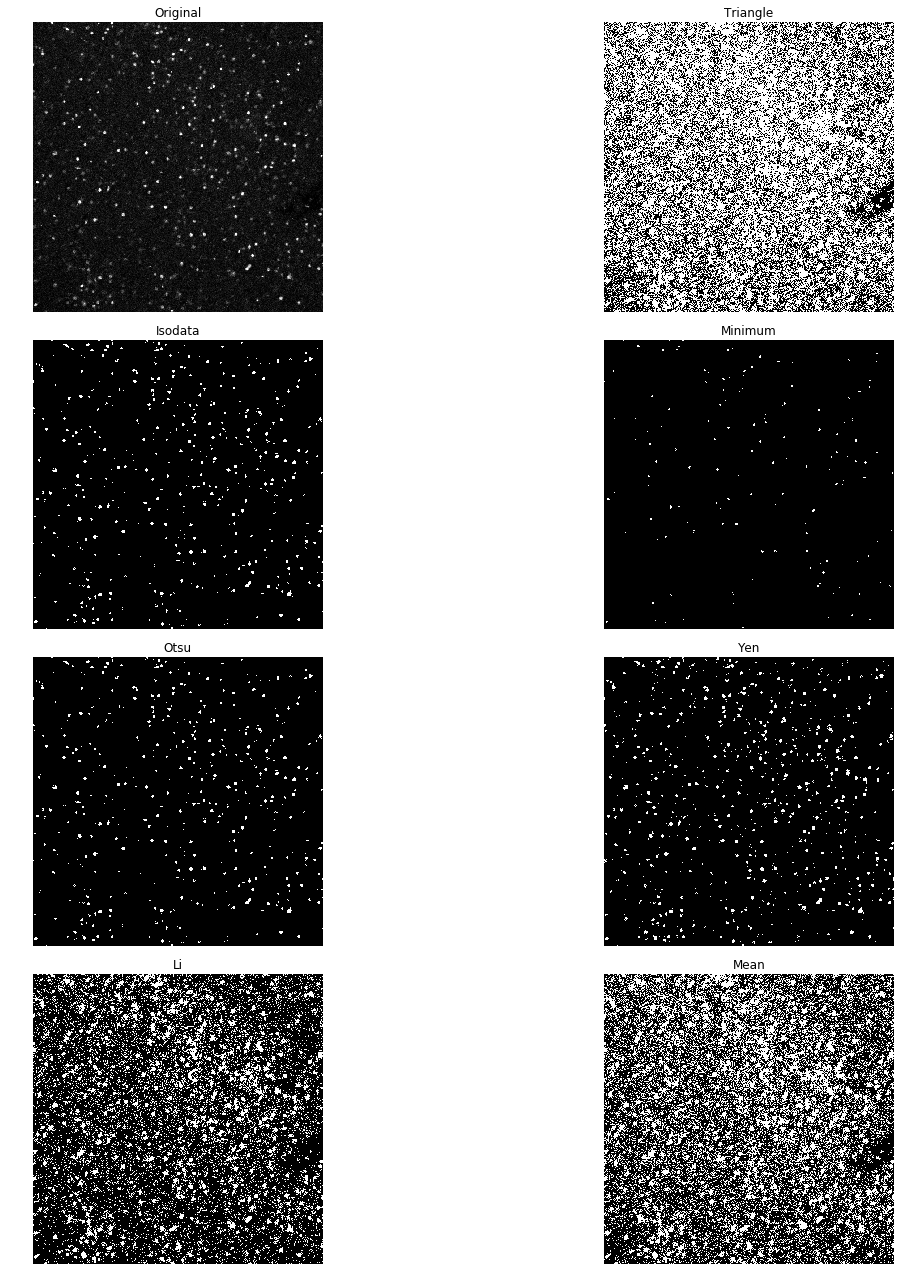

In [23]:
try_all_threshold(PI, figsize=(20,18))

skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_yen


(<Figure size 1440x1296 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11422c080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11425ada0>], dtype=object))

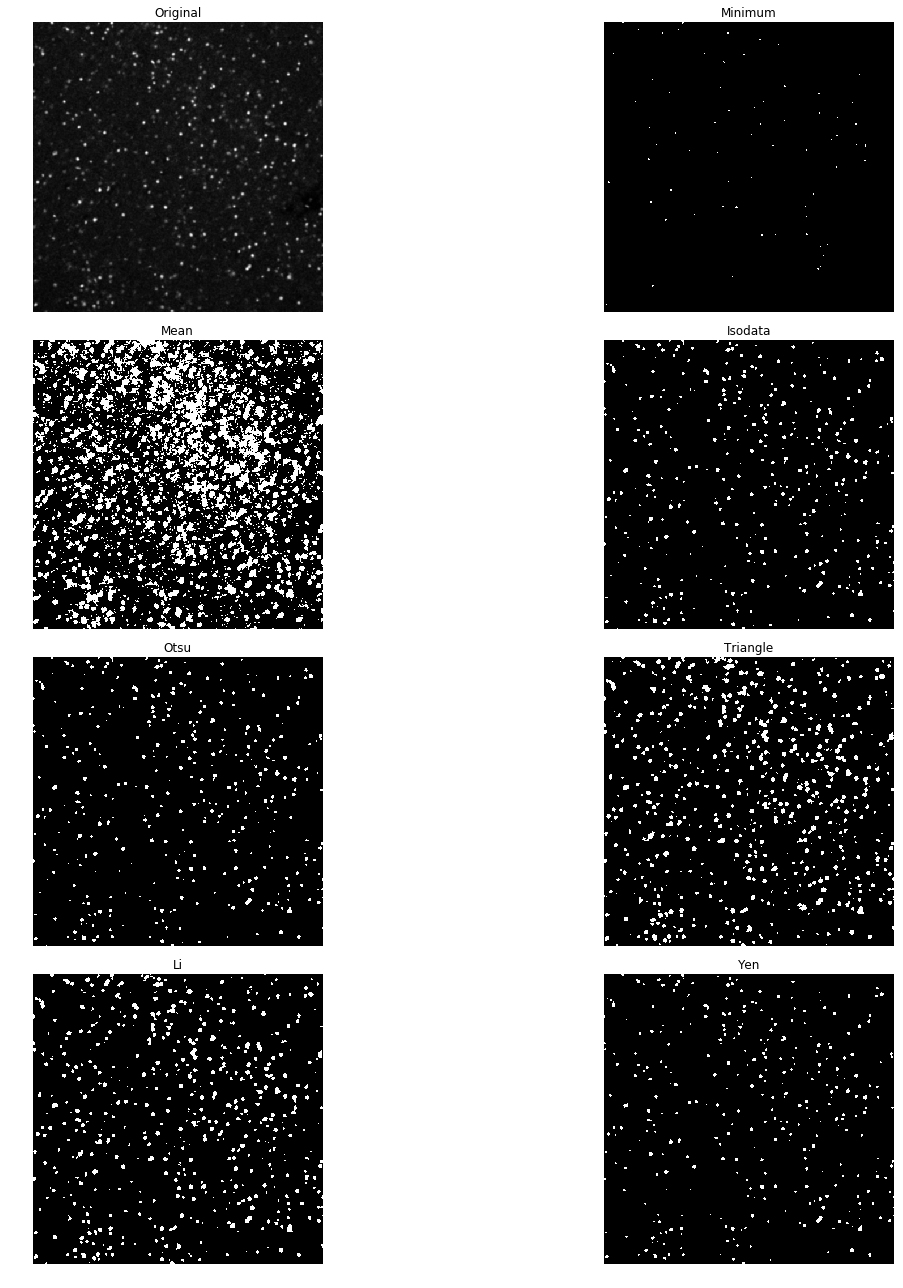

In [17]:
try_all_threshold(PI_filtered, figsize=(20,18))

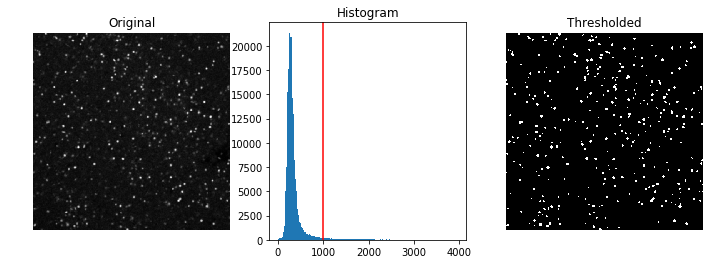

In [13]:
PI_thresh = skimage.filters.threshold_otsu(PI_filtered)
PI_binary = PI_filtered > PI_thresh

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(PI_filtered, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(PI_filtered.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(PI_thresh, color='r')

ax[2].imshow(PI_binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

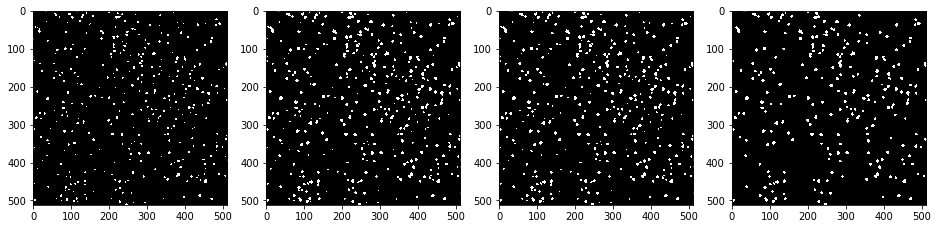

In [14]:
PI_dilation = skimage.morphology.binary_dilation(PI_binary)
PI_filled_holes = ndi.binary_fill_holes(PI_dilation)
PI_clean = skimage.morphology.remove_small_objects(PI_filled_holes, min_size=30)


fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
ax = axes.ravel()
ax[0] = plt.subplot(1, 4, 1)
ax[1] = plt.subplot(1, 4, 2)
ax[2] = plt.subplot(1, 4, 3)
ax[3] = plt.subplot(1, 4, 4)
ax[0].imshow(PI_binary, cmap=plt.cm.gray)
ax[1].imshow(PI_dilation, cmap=plt.cm.gray)
ax[2].imshow(PI_filled_holes, cmap=plt.cm.gray)
ax[3].imshow(PI_clean, cmap=plt.cm.gray)
plt.show()

In [15]:
labeled_PI, _ = ndi.label(PI_clean)
PI_props = measure.regionprops(labeled_PI)

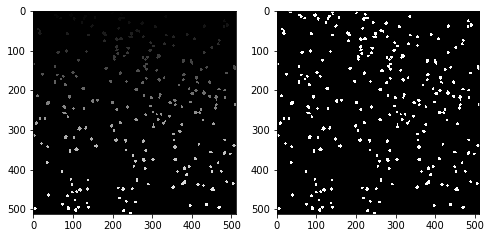

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[1] = plt.subplot(1, 2, 2)
ax[0].imshow(labeled_PI, cmap=plt.cm.gray)
ax[1].imshow(PI_clean, cmap=plt.cm.gray)

plt.show()

In [17]:
print(len(PI_props))
props_PI = pd.DataFrame(columns=['centroid x', 'centroid y', 'filled_area', 'area'])

k = 1
for props in PI_props:
    #Get the properties that I need for areas
    #Add them into a pandas dataframe that has the same number of rows as objects detected
    #
    centroid = props.centroid
    centroid_x = centroid[0]
    centroid_y = centroid[1]
    fill_area = props.filled_area
    area = props.area
    props_PI.loc[k] = [centroid_x, centroid_y, fill_area, area]
    k = k + 1

229


## Final Calcs

In [20]:


PI_overlap_sum = 0
DAPI_pixels = 0
i = 0
PI_pixels = 0

for ydim in range(0,512):
    for xdim in range(0,512):
        if labeled_DAPI[ydim][xdim] != 0:
            PI_overlap_sum = PI_overlap_sum + PI[ydim][xdim]
            DAPI_pixels = DAPI_pixels+1
            i = i + 1
            if labeled_PI[ydim][xdim] != 0:
                PI_pixels = PI_pixels + 1

In [21]:
print(i)
print(PI_overlap_sum)
print(PI_pixels)
print(DAPI_pixels)
print(PI_pixels/DAPI_pixels)

16168
18389175
9431
16168
0.5833127164769916


In [25]:
output_data = pd.DataFrame(columns=['DAPI count','DAPI intensity', 'DAPI area', 'PI count', 'PI intensity', 'PI area', 'PI w/in DAPI area', '%overlap PI/DAPI'])

In [26]:
output_data = output_data.append({'DAPI count':len(props_DAPI), 'PI count':len(props_PI), 'DAPI intensity':DAPI.sum(), 'PI intensity':PI.sum(), 'DAPI area':props_DAPI['area'].sum(), 'PI area':props_PI['area'].sum(), 'PI w/in DAPI area':PI_overlap_sum, '%overlap PI/DAPI':PI_pixels/DAPI_pixels}, ignore_index=True)

In [27]:
output_data

,DAPI count,DAPI intensity,DAPI area,PI count,PI intensity,PI area,PI w/in DAPI area,%overlap PI/DAPI
0,281.0,149403597.0,16168.0,229.0,95169023.0,11425.0,18389175.0,0.583313


0.19322647664461157